In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from numpy.polynomial import chebyshev
from numpy.polynomial import legendre
from scipy.interpolate import approximate_taylor_polynomial

# Problem 1

Solution of Griffith 2.7:

$
E(z) = \frac{R^2 \sigma}{2 \varepsilon_0} \int_0^\pi \frac{(z - R \cos \theta) \sin \theta}{(R^2 + z^2 - 2Rz \cos \theta)^{3/2}} d \theta
$

For simplisity, I set $R = 1$, $\sigma = 1$, $\varepsilon = 1$.

There is a singularity in the integral at the point $z = R$. `scipy.quad` handles it easily - just takes average of func($x_0 - \epsilon$) and func($x_0 + \epsilon$), where $x_0$ - coordinate of singularity and $\epsilon \rightarrow 0$. Custom integrator (in this case - Simpson's rule) can't solve this problem, so returns a `NaN` because of division by zero.

In [2]:
def simpsons(func, a, b, npoints=5):
    "My implementation of general Simson's rule for n points"
    if npoints % 2 == 0:
        npoints += 1
        
    coefs = np.empty(npoints)
    coefs[[0, -1]] = 1
    coefs[1::2] = 4
    coefs[2:-1:2] = 2
    
    dx = (b - a) / (npoints - 1)
    x = np.linspace(a, b, npoints)
    y = func(x)
    
    return dx / 3 * coefs @ y


def inner_func(z, theta):
        "Function under the integral"
        return 0.5 * (z - np.cos(theta)) * np.sin(theta) / np.abs(np.power(1 + z**2 - 2 * z * np.cos(theta), 1.5))

/tmp/ipykernel_6976/3804645111.py:20: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * (z - np.cos(theta)) * np.sin(theta) / np.abs(np.power(1 + z**2 - 2 * z * np.cos(theta), 1.5))


scipy.quad value at z=R:	0.5
Custom integrator value at z=R:	nan


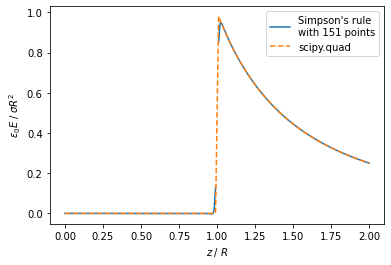

In [3]:
z = np.linspace(0, 2, 201)

E_quad = np.array([quad(lambda t: inner_func(z_i, t), 0, np.pi)[0] for z_i in z])

npoints = 151
E_simp = np.array([simpsons(lambda t: inner_func(z_i, t), 0, np.pi, npoints=npoints) for z_i in z])

print(f"scipy.quad value at z=R:\t{E_quad[z==1][-1]:.1f}")
print(f"Custom integrator value at z=R:\t{E_simp[z==1][-1]:.1f}")

plt.plot(z, E_simp, linestyle='-', label=f"Simpson's rule\nwith {npoints} points")
plt.plot(z, E_quad, linestyle='--', label='scipy.quad')
plt.ylabel(r"$\varepsilon_0 E \; /\; \sigma R^2 $")
plt.xlabel(r"$z\;/\;R$")
plt.legend()
plt.show()

# Problem 2

Smaller tolerance requires more steps for integration, which means more function evaluations. Written algorithm uses 5 point Simpson's rule. In the worst case scenario, a non-optimized algorithm with interval splitting depth $n$ will make $N_{e5} = 5(2^1 + 2^2 + 2^3 + ... 2^n)$ evaluations. In case of optimized algorithm, we can reduce number of evaluations to two on each iteration, starting from the second iteration. So $N_{e2} = 5 + 2(2^1 + 2^2 + 2^3 + ... 2^n)$. The best potential speed boost we can get is:

$
\lim_{n\to\infty}\frac{N_{e5}}{N_{e2}} = \frac{5 \cdot 2^n}{2 \cdot 2^n} = 2.5$

On the final plots we can see something very similar to 2.5 for small tolerances.

In [4]:
def integrate_adaptive_class(fun, x0, x1, tol, count_evals=False):
    """
    Implementation from classes with modification to count and return number of func. evaluations
    """
    #hardwire to use simpsons
    x = np.linspace(x0, x1, 5)
    y = fun(x)
    dx =(x1 - x0) / (len(x) - 1)
    area1 = 2 * dx * (y[0] + 4 * y[2] + y[4])/3 #coarse step
    area2 = dx * (y[0] + 4 * y[1] + 2 * y[2] + 4 * y[3] + y[4]) / 3 #finer step
    err = np.abs(area1 - area2)
    if err < tol:
        if count_evals:
            return area2, 5
        else:
            return area2
    else:
        xmid = (x0 + x1) / 2
        if count_evals:
            left, ecl = integrate_adaptive_class(fun, x0, xmid, tol / 2, count_evals=True)
            right, ecr = integrate_adaptive_class(fun, xmid, x1, tol / 2, count_evals=True)
            return left + right, ecl + ecr
        else:
            left = integrate_adaptive_class(fun, x0, xmid, tol / 2)
            right = integrate_adaptive_class(fun, xmid, x1, tol / 2)
            return left + right
    

def integrate_adaptive(fun, a, b, tol, extra=None, count_evals=False):
    """
    My implementation. Every time interval is divided in half, we already know 3 of 5 function values.
    1 2 3 4 5 -> 1 ? 2 ? 3 || 3 ? 4 ? 5
    where 1-5 - known values, ? - unknown (new) values. So after first iteration, parameter extra will 
    always be a np.array with shape = (3,)
    """
    x = np.linspace(a, b, 5)
    if extra is None:
        y = fun(x)
    else:
        y = np.empty(5)
        y[[0,2,4]] = extra
        y[[1,3]] = fun(x[[1,3]])
    dx = (b - a) / (len(x) - 1)
    area1 = 2 * dx * (y[0] + 4 * y[2] + y[4]) / 3
    area2 = dx * (y[0] + 4 * y[1] + 2 * y[2] + 4 * y[3] + y[4]) / 3
    err = np.abs(area1 - area2)
    
    if err < tol:
        if count_evals:
            return area2, 5 if extra is None else 2
        else:
            return area2
    else:
        xmid = (a + b) / 2
        if count_evals:
            left, ecl = integrate_adaptive(fun, a, xmid, tol/2, extra = y[:3], count_evals=True)
            right, ecr = integrate_adaptive(fun, xmid, b, tol/2, extra = y[-3:], count_evals=True)
            return left + right, ecl + ecr
        else:
            left = integrate_adaptive(fun, a, xmid, tol/2, extra = y[:3])
            right = integrate_adaptive(fun, xmid, b, tol/2, extra = y[-3:])
            return left + right

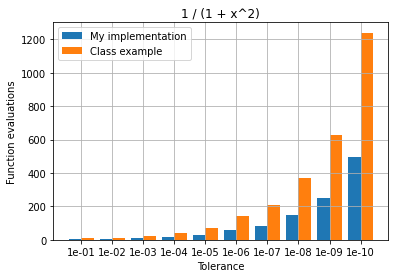

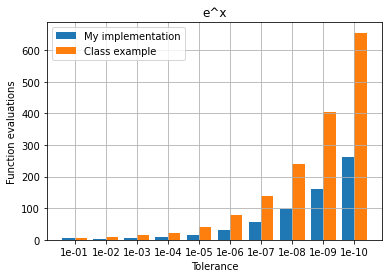

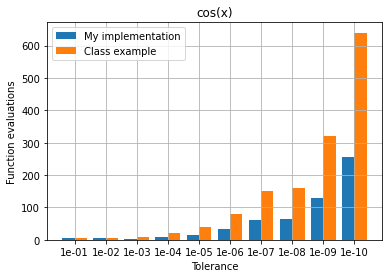

In [5]:
# Testing

funcs = {
    "1 / (1 + x^2)": lambda x: 1  / (1 + x * x),
    "e^x": np.exp,
    "cos(x)": lambda x: np.cos(x),
}
    
x = np.linspace(-1, 1)

errors = np.logspace(-1, -10, 10)

for key in funcs.keys():
    evals1 = np.empty(errors.shape)
    evals2 = np.empty(errors.shape)

    for i in range(len(errors)):
        _, eval1 = integrate_adaptive_class(funcs[key], np.min(x), np.max(x), tol=errors[i], count_evals=True)
        _, eval2 = integrate_adaptive(funcs[key], np.min(x), np.max(x), tol=errors[i], count_evals=True)
        evals1[i] = eval1
        evals2[i] = eval2

    ind = np.arange(len(errors))
    width = 0.4
    plt.bar(ind, evals2, label='My implementation', width=width)
    plt.bar(ind + width, evals1, label='Class example', width=width)
    plt.gca().set_xticks(ind + width / 2)
    plt.gca().set_xticklabels([f"{e:.0e}" for e in errors])
    plt.ylabel('Function evaluations')
    plt.xlabel('Tolerance')
    plt.grid()
    plt.title(key)
    plt.legend()
    plt.show()

# Problem 3

In the first block I fit Chebyshev polynomials with different orders to estimate the optimal one. From the bar chart one can see, that 6th order has error $\sim 10^{-7}$, so I chose 7th order to make the error strictly $< 10^{-7}$.

$
\log_e x = \frac{\log_2 x}{\log_2 e}
$

`np.frexp(x)` returns mantisa $m$ and exponent $e$, so $x = m \cdot 2^e$. Then $\log_2 x = \log (m) + e$. For positive x $0.5 <= m <= 1$. To calculate $\log (m)$ I use Chebyshev polinomials of 7th order.

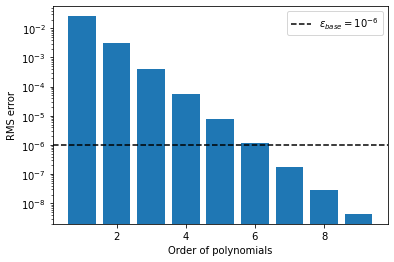

In [113]:
# Finding best order

npoints = 100
x = np.linspace(0.5, 1, npoints)
y = np.log2(x)

orders = np.arange(1, 10)
errors = np.empty(orders.shape)
for i in range(len(orders)):
    _, errs = chebyshev.chebfit(x, y, orders[i], full=True)
    # rms err = sqrt(squared_residuals / n-1)
    errors[i] = np.sqrt(errs[0] / (npoints - 1))


plt.bar(orders, errors)
plt.gca().axhline(1e-6, color='k', linestyle='--', label=r'$\varepsilon_{base} = 10^{-6}$')
plt.yscale('log')
plt.ylabel('RMS error')
plt.xlabel('Order of polynomials')
plt.legend()
plt.show()

In [114]:
# Calculation of constant coefs which will be used in mylog2
coefs7 = chebyshev.chebfit(x, y, 7)

# Calculation of the log_2(e) which will be used in mylog2
man_e, exp_e = np.frexp(np.e)
log2e = chebyshev.chebval(man_e, coefs7) + exp_e

def mylog2(x):
    man, exp = np.frexp(x)
    return (chebyshev.chebval(man, coefs7) + exp) / log2e

RMS error of calculation:	1.4e-07


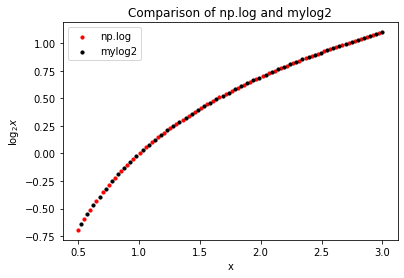

In [125]:
# Test 
x = np.linspace(0.5, 3, 100)
lognp = np.log(x)
logmy = mylog2(x)

err = np.sqrt(np.mean(np.power(lognp - logmy, 2)))
print(f"RMS error of calculation:\t{err:.1e}")

plt.scatter(x[0::2], lognp[0::2], s=10, c='r', label='np.log')
plt.scatter(x[1::2], logmy[1::2], s=10, c='k', label='mylog2')
plt.xlabel('x')
plt.ylabel(r'$\log_2 x$')
plt.title("Comparison of np.log and mylog2")
plt.legend()
plt.show()